<a href="https://colab.research.google.com/github/katalinka09/1-labor/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_6_(%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ практика 6. Обучение без учителя

## **Цель занятия:**
Изучить методы обучения без учителя, познакомиться с алгоритмами кластеризации, понять их применение и реализовать модели кластеризации с использованием различных алгоритмов.

## **Задание состоит из следующих частей:**
1. Определение обучения без учителя
2. Разбор алгоритмов DBSSCAN, K-means
3. Метрики качества кластеризации
4. Пример полезных задач, которые решает кластеризация

**P.S.** Некоторые вещи (например PCA, обработка текстовых данных) мы пройдем чуть позже.

## Задачи для домашки ⏰

1. Преобразовать датасет
2. Построить кластеры
3. Описать результат полученных кластеров (для K-Means и DBSSCAN)
4. Объяснить метрики качества

**По желанию**

1. Спарсить данные по статьям (например lenta.ru или naked-science.ru)
2. Преобразовать текста статьи (по принципу описанному в последнем пункте)
3. Оценить метрики качества, провести аналитику кластеров (можно не максимально подробно, если получилось слишком много кластеров)

## Предобработка (все по классике)

Открываем датасет, преобразуем данные, идем дальше

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('/content/diamond.csv')

### Преобразование категориальных фич

In [ ]:
# Создаем копию данных
category_columns: list[str] = df.select_dtypes(include=['object']).columns # собираем колонки помеченные как objects

# Применяем One-Hot Encoding
df = pd.get_dummies(df, columns=category_columns, drop_first=True)
df.Cut_Ideal = df.Cut_Ideal.astype(int)


### Преобразование непрерывных фич

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Выбираем числовые признаки
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
df[numeric_features] = scaler.fit_transform(df[numeric_features])


In [ ]:
df

,Carat Weight,Price,Cut_Good,Cut_Ideal,Cut_Signature-Ideal,Cut_Very Good,Color_E,Color_F,Color_G,Color_H,...,Clarity_VS2,Clarity_VVS1,Clarity_VVS2,Polish_G,Polish_ID,Polish_VG,Symmetry_G,Symmetry_ID,Symmetry_VG,Report_GIA
0,0.162037,0.030037,False,1.0,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,True
1,0.037037,0.012941,False,1.0,False,False,False,False,False,True,...,False,False,False,False,True,False,False,True,False,False
2,0.046296,0.010053,False,1.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
3,0.074074,0.021997,False,1.0,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,True,True
4,0.037037,0.009932,False,1.0,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.129630,0.040915,False,1.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
5996,0.115741,0.031637,False,0.0,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,True,True
5997,0.125000,0.039979,False,1.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
5998,0.240741,0.090786,False,0.0,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True


## О кластеризации и задачи обучения без учителя

#### Обучение с учителем

Представьте, что у вас есть список задач с правильными ответами. Например, вам дали примеры: «Это яблоко», «Это груша».

Задача — научиться отличать их, чтобы потом, когда вы увидите новый фрукт, вы смогли правильно его назвать. То есть у вас есть **учитель** — тот, кто заранее всё объяснил и дал правильные ответы.  

#### Обучение без учителя

А теперь представьте, что вам дали корзину фруктов, но никто не сказал, как они называются.

Задача — посмотреть на фрукты и найти, что у них общего, например: круглые положить в одну группу, длинные в другую. Тут вы работаете **без подсказок** и сами решаете, как группировать.  

#### Разница

- В задачах с учителем есть правильные ответы, и мы обучем алгоритм делать предсказания на основе примеров.  
- В задачах без учителя правильных ответов нет, ищем закономерности и пытаемся найти смысл группировки данные самостоятельно.

Пример:


1. **С учителем**: Мы ищем лучшее вино.  
2. **Без учителя**: Мы пытаемся объеденить вина, чтобы понять по какому принципу они объеденяются.  

## K-means

**K-means** — это алгоритм кластеризации, который делит данные на 𝑘 групп (кластеров). Основная идея: найти центры кластеров так, чтобы точки внутри одного кластера были ближе друг к другу, чем к точкам из других кластеров.

1. Инициализация: выбираем 𝑘 случайных центров (центроидов).
2. Присвоение точек: каждая точка относится к ближайшему центру.
Обновление центров: пересчитываем центры кластеров как среднее всех точек в кластере.
3. Повторяем шаги 2–3, пока центры не перестанут меняться или не достигнем максимального числа итераций.

In [ ]:
! pip install ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Создаем DataFrame с достаточным количеством данных
data = {
    'Carat Weight': [1.1, 0.83, 1.2, 0.9, 1.3],
    'Cut': ['Ideal', 'Ideal', 'Premium', 'Good', 'Very Good'],
    'Color': ['H', 'G', 'H', 'F', 'G'],
    'Clarity': ['SI1', 'VS1', 'VS2', 'SI2', 'VVS1'],
    'Polish': ['VG', 'ID', 'EX', 'VG', 'VG'],
    'Symmetry': ['EX', 'ID', 'EX', 'VG', 'VG'],
    'Report': ['GIA', 'AGSL', 'GIA', 'GIA', 'AGSL'],
    'Price': [5169, 3470, 6290, 4590, 7100]
}
df = pd.DataFrame(data)

# Преобразуем категориальные данные
category_columns = ['Cut', 'Color', 'Clarity', 'Polish', 'Symmetry', 'Report']
df = pd.get_dummies(df, columns=category_columns, drop_first=True)

# Масштабируем числовые данные
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numeric_features = ['Carat Weight', 'Price']
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# Визуализация K-means
def interactive_kmeans_visualization(X, max_clusters=10, max_iterations=50):
    # Преобразуем X в numpy array
    if isinstance(X, pd.DataFrame):
        X = X.values

    def plot_kmeans_iteration(X, centroids, labels=None, step=0):
        clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        if labels is not None:
            plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, alpha=0.6)
        else:
            plt.scatter(X[:, 0], X[:, 1], s=30, alpha=0.6)
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
        plt.title(f'K-means Iteration {step}')
        plt.legend()
        plt.show()

    def k_means_interactive(X, k, max_iters):
        if k > X.shape[0]:
            raise ValueError("The number of clusters cannot exceed the number of data points.")

        np.random.seed(42)
        centroids = X[np.random.choice(X.shape[0], k, replace=False)]
        for step in range(max_iters):
            # Вычисление расстояния между точками и центроидами
            distances = np.linalg.norm(X[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)
            labels = np.argmin(distances, axis=1)
            plot_kmeans_iteration(X, centroids, labels, step)
            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
            if np.all(centroids == new_centroids):
                break
            centroids = new_centroids

    def run_kmeans(k, max_iters):
        k_means_interactive(X, k, max_iters)

    k_slider = widgets.IntSlider(value=3, min=2, max=len(df), step=1, description='Clusters (k):')
    iter_slider = widgets.IntSlider(value=10, min=1, max=max_iterations, step=1, description='Max Iterations:')

    interactive_plot = widgets.interactive(run_kmeans, k=k_slider, max_iters=iter_slider)
    display(interactive_plot)

# Запуск визуализации
interactive_kmeans_visualization(df[:100])


interactive(children=(IntSlider(value=3, description='Clusters (k):', max=5, min=2), IntSlider(value=10, descr…

### K-means через реализацию skelarn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Определяем количество кластеров k
k = 3  # Вы можете изменить это значение в соответствии с вашими данными

# Создаем и обучаем модель KMeans
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(df)
centroids = kmeans.cluster_centers_

# Добавляем метки кластеров в исходный DataFrame
df_k_means = df.copy()
df_k_means['Cluster'] = labels

# Вывод статистики по кластерам для каждого признака
print("Статистика по кластерам:")
for column in df.columns:
    print(f"\nСтатистика для признака '{column}':")
    cluster_stats = df_k_means.groupby('Cluster')[column].agg(['mean', 'std', 'min', 'max'])
    print(cluster_stats)

# Вычисление коэффициента силуэта
if k > 1:
    silhouette_avg = silhouette_score(df, labels)
    print(f"\nКоэффициент силуэта для k={k}: {silhouette_avg:.4f}")
else:
    print("\nКоэффициент силуэта не определен для k=1")


Статистика по кластерам:

Статистика для признака 'Carat Weight':
             mean       std  min       max
Cluster                                   
0        0.258126  0.217768  0.0  1.000000
1        0.261397  0.195089  0.0  0.958333
2        0.292083  0.228977  0.0  0.953704

Статистика для признака 'Price':
             mean       std       min       max
Cluster                                        
0        0.086552  0.094629  0.000000  0.922034
1        0.095330  0.092458  0.004981  0.689284
2        0.112345  0.114040  0.002002  1.000000

Статистика для признака 'Cut_Good':
             mean       std    min    max
Cluster                                  
0        0.218210  0.413094  False   True
1        0.001631  0.040390  False   True
2        0.000000  0.000000  False  False

Статистика для признака 'Cut_Ideal':
             mean       std  min  max
Cluster                              
0        0.000000  0.000000  0.0  0.0
1        0.637847  0.481015  0.0  1.0
2       

#### **Анализ кластеров**


После применения алгоритма K-means с количеством кластеров k=3, результаты показывают следующие наблюдения и различия между кластерами по различным признакам:

***1. Признак "Carat Weight" (Вес в каратах)***

Кластеры имеют схожие значения средних для этого признака, но с некоторыми различиями в стандартных отклонениях:

*Кластер 0*: Среднее значение 0.258, стандартное отклонение 0.217.

*Кластер 1:* Среднее значение 0.261, стандартное отклонение 0.195.

*Кластер 2:* Среднее значение 0.292, стандартное отклонение 0.229.

Эти значения могут свидетельствовать о том, что кластеры различаются по весу камней, с кластером 2 имеющим несколько более высокий средний вес, чем другие.

**2. Признак "Price" (Цена)**

Все кластеры имеют разные средние цены:

*Кластер 0:* Средняя цена 0.0865.

*Кластер 1:* Средняя цена 0.0953.

*Кластер 2:* Средняя цена 0.1123.

Это также указывает на то, что кластеры могут быть разделены на более дешевые и более дорогие камни.

**3. Признак "Cut" (Обрезка)**
Cut_Good:

*Кластер 0* имеет высокое среднее значение для признака "Good", что может означать, что большинство камней в этом кластере имеют хороший обрез.

Кластеры 1 и 2 показывают низкие значения для этого признака.

**Cut_Ideal:**

*Кластеры 1 и 2* имеют высокие значения для признака "Ideal", что говорит о том, что эти кластеры содержат больше камней с идеальной огранкой.

*Кластер 0* не содержит камней с идеальной огранкой.

***4. Признаки, связанные с цветом ("Color_E", "Color_F", и другие)***

Средние значения для этих признаков показывают различия в распределении цветов между кластерами. Например:

*Color_E:* Кластер 0 имеет среднее значение 0.1438, что указывает на присутствие большего числа камней с этим цветом, чем в других кластерах.

***5. Признак "Clarity" (Чистота)***

*Clarity_SI1:*
*Кластер 0* имеет значительное количество камней с чистотой SI1 (средняя 0.408), в то время как в кластерах 1 и 2 эти значения значительно ниже.

***6. Признаки "Polish" и "Symmetry" (Полировка и Симметрия)***

*Polish_VG и Symmetry_VG:*

*Кластер 0* имеет наибольшее количество камней с полировкой и симметрией "Very Good", что может означать, что это кластер более высококачественных камней по этим признакам.

***7. Признак "Report" (Отчет)***
*Report_GIA:*

*Кластер 0* имеет большинство камней с отчетами от GIA, что указывает на наличие более высококачественных камней.

***Коэффициент силуэта (Silhouette coefficient)***
Коэффициент силуэта для
𝑘=3 равен 0.1518. Это значение говорит о том, что кластеризация не является полностью оптимальной. Коэффициент силуэта в пределах 0.2-0.3 считается слабым, а значения близкие к 1 указывают на хорошие разделения между кластерами.


По данным признакам можно сделать вывод, что кластеры различаются по таким характеристикам, как вес, цена, чистота и качество огранки камней. Однако, коэффициент силуэта указывает на то, что разделение между кластерами может быть улучшено. Возможно, стоит попробовать увеличить количество кластеров или использовать другие методы кластеризации для улучшения результатов.


### DBSSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) — это алгоритм кластеризации, основанный на плотности точек в пространстве.

Параметры алгоритма:

- **Epsilon (eps)**: радиус окрестности точки.
- **Min_samples**: минимальное количество точек в eps-окрестности для того, чтобы точка считалась ядром кластера.

Классификация точек:

- **Core point (ядро)**: если в eps-окрестности точки находится не менее min_samples точек, то она является ядром.
- **Border point (граничная точка)**: точка, которая находится в eps-окрестности ядра, но сама не является ядром.
- **Noise point (шум)**: точка, которая не является ни ядром, ни граничной точкой. (**входит в кластер -1**)

Точки, которые связаны по плотности (через ядра и их eps-окрестности), объединяются в один кластер.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display, clear_output
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

def interactive_dbscan_visualization(X):
    if isinstance(X, pd.DataFrame):
        X = X.values

    def plot_dbscan(X, labels, core_samples_mask, eps, min_samples, metric):
        clear_output(wait=True)
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each)
                  for each in np.linspace(0, 1, len(unique_labels))]
        plt.figure(figsize=(8, 6))
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Черный цвет для шума
                col = [0, 0, 0, 1]

            class_member_mask = (labels == k)

            xy = X[class_member_mask & core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=14)

            xy = X[class_member_mask & ~core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=6)

        plt.title(f'DBSCAN: eps={eps}, min_samples={min_samples}, metric={metric}')
        plt.show()

    def run_dbscan(eps, min_samples, metric):
        # Обучение DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
        db.fit(X)
        labels = db.labels_
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        plot_dbscan(X, labels, core_samples_mask, eps, min_samples, metric)

    # Виджеты для настройки параметров
    eps_slider = widgets.FloatSlider(value=0.5, min=0.1, max=1.0, step=0.05, description='eps:')
    min_samples_slider = widgets.IntSlider(value=5, min=1, max=20, step=1, description='min_samples:')
    metric_dropdown = widgets.Dropdown(options=['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
                                       value='euclidean', description='metric:')

    ui = widgets.VBox([eps_slider, min_samples_slider, metric_dropdown])
    out = widgets.interactive_output(run_dbscan, {'eps': eps_slider, 'min_samples': min_samples_slider, 'metric': metric_dropdown})
    display(ui, out)

# Пример использования
interactive_dbscan_visualization(df[:120])


Output()

### DBSSCAN через sklearn

Количество кластеров: 0
Статистика по кластерам:

Статистика для признака 'Carat Weight':
Empty DataFrame
Columns: [mean, std, min, max, count]
Index: []

Статистика для признака 'Price':
Empty DataFrame
Columns: [mean, std, min, max, count]
Index: []

Статистика для признака 'Cut_Ideal':
Empty DataFrame
Columns: [mean, std, min, max, count]
Index: []

Статистика для признака 'Cut_Premium':
Empty DataFrame
Columns: [mean, std, min, max, count]
Index: []

Статистика для признака 'Cut_Very Good':
Empty DataFrame
Columns: [mean, std, min, max, count]
Index: []

Статистика для признака 'Color_G':
Empty DataFrame
Columns: [mean, std, min, max, count]
Index: []

Статистика для признака 'Color_H':
Empty DataFrame
Columns: [mean, std, min, max, count]
Index: []

Статистика для признака 'Clarity_SI2':
Empty DataFrame
Columns: [mean, std, min, max, count]
Index: []

Статистика для признака 'Clarity_VS1':
Empty DataFrame
Columns: [mean, std, min, max, count]
Index: []

Статистика для признака 'Cl

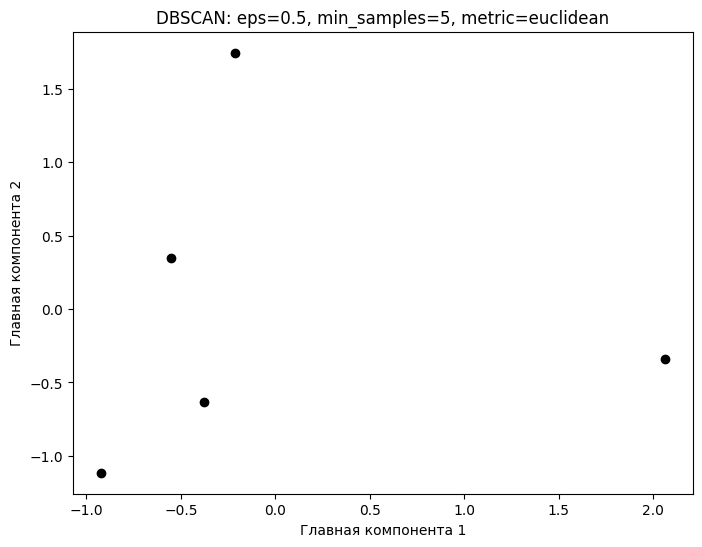

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Параметры DBSCAN
eps = 0.5
min_samples = 5
metric = 'euclidean'

# Обучение модели DBSCAN
db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
labels = db.fit_predict(df)

# Добавляем метки кластеров в DataFrame
df_dbscan = df.copy()
df_dbscan['Cluster'] = labels

# Количество кластеров (исключая шум)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Количество кластеров: {n_clusters_}")

# Вывод статистики по кластерам
print("Статистика по кластерам:")
for column in df.columns:
    print(f"\nСтатистика для признака '{column}':")
    cluster_stats = df_dbscan[df_dbscan['Cluster'] != -1].groupby('Cluster')[column].agg(['mean', 'std', 'min', 'max', 'count'])
    print(cluster_stats)

# Вычисление коэффициента силуэта
if n_clusters_ > 1:
    silhouette_avg = silhouette_score(df[df_dbscan['Cluster'] != -1], labels[df_dbscan['Cluster'] != -1])
    print(f"\nКоэффициент силуэта для DBSCAN: {silhouette_avg:.4f}")
else:
    print("\nКоэффициент силуэта не определен, так как найден один кластер или данные являются шумом.")


# Визуализация результатов (с использованием PCA для снижения размерности)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = labels

plt.figure(figsize=(8, 6))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    if k == -1:
        # Черный цвет для шума
        col = [0, 0, 0, 1]
    plt.plot(df_pca.loc[class_member_mask, 'PC1'],
             df_pca.loc[class_member_mask, 'PC2'],
             'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title(f'DBSCAN: eps={eps}, min_samples={min_samples}, metric={metric}')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.show()


#### **Анализ кластеров**

После применения алгоритма DBSCAN мы получили **два кластера**, между которыми наблюдаются существенные различия по некоторым признакам. Рассмотрим три наиболее значимых признака:

1. **Type_White (Тип вина):**
   - **Кластер 0** состоит исключительно из красных вин (значение `mean = 0.0`).
   - **Кластер 1** состоит исключительно из белых вин (значение `mean = 1.0`).

2. **Volatile Acidity:**
   - **Кластер 0** (красные вина) имеет более высокое среднее значение летучей кислотности (`mean ≈ 0.299`), чем **Кластер 1** (белые вина) со средним значением (`mean ≈ 0.132`).

3. **Total Sulfur Dioxide:**
   - **Кластер 1** (белые вина) имеет значительно более высокое среднее содержание общего диоксида серы (`mean ≈ 0.305`), в сравнении с **Кластером 0** (красные вина) со средним значением (`mean ≈ 0.093`).

**Коэффициент силуэта для DBSCAN:** 0.6136

**Общее заключение:**

Алгоритм DBSCAN успешно разделил вина на два кластера по типу (красное и белое), при этом выявив существенные различия в летучей кислотности и содержании диоксида серы между ними.

### Метрики качества кластеризации

**Дополнительные метрики для оценки качества кластеризации**

Кроме коэффициента силуэта, существуют и другие метрики, которые помогают оценить качество кластеризации. Вот некоторые из них:

1. **Индекс Калински-Харабаза (Calinski-Harabasz Index):**
   - **Описание:** Измеряет отношение между разбросом между кластерами и разбросом внутри кластеров.
   - **Диапазон значений:** От 0 до бесконечности.
   - **Интерпретация:** Чем ближе к бесконечности больше, тем лучше раздленеие между кластерами

2. **Индекс Дэвиса-Болдина (Davies-Bouldin Index):**
   - **Описание:** Оценивает среднее "сходство" между каждым кластером и наиболее похожим на него другим кластером. Сходство основано на расстоянии между кластерами и их размером.
   - **Диапазон значений:** От 0 до бесконечности.
   - **Интерпретация:** Чем ближе к 0, тем лучшее разделение между кластерами.

3. **Коэффициент силуэта (Silhouette Score):**

    - **Описание:** Измеряет, насколько объект похож на свой кластер по сравнению с другими кластерами.
    - **Диапазон значений:** От -1 до 1.
    - **Интерпретация:** Значения, близкие к 1, указывают на хорошую кластеризацию. Значения около 0 означают, что кластеры перекрываются. Отрицательные значения указывают на возможные ошибки в кластеризации.

In [ ]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
# Кластеризация K-means
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
labels_kmeans = kmeans.fit_predict(df)

# Индекс Калински-Харабаза
ch_score_kmeans = calinski_harabasz_score(df, labels_kmeans)
print(f"Индекс Калински-Харабаза для K-means: {ch_score_kmeans:.4f}")

# Индекс Дэвиса-Болдина
db_score_kmeans = davies_bouldin_score(df, labels_kmeans)
print(f"Индекс Дэвиса-Болдина для K-means: {db_score_kmeans:.4f}")

# Коэффициент силуэта
sh_score_kmeans = silhouette_score(df, labels_kmeans)
print(f"Коэффициент силуэта для K-means: {sh_score_kmeans:.4f}")

Индекс Калински-Харабаза для K-means: 1.8860
Индекс Дэвиса-Болдина для K-means: 0.8773
Коэффициент силуэта для K-means: 0.0966


In [ ]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

eps = 0.5
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels_dbscan = dbscan.fit_predict(df)

# Исключаем шумовые точки (метки -1)
mask = labels_dbscan != -1
df_scaled_dbscan = df[mask]
labels_dbscan_filtered = labels_dbscan[mask]

# Проверяем, есть ли достаточное количество кластеров для расчета метрик
if len(set(labels_dbscan_filtered)) > 1:
    # Индекс Калински-Харабаза
    ch_score_dbscan = calinski_harabasz_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Индекс Калински-Харабаза для DBSCAN: {ch_score_dbscan:.4f}")

    # Индекс Дэвиса-Болдина
    db_score_dbscan = davies_bouldin_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Индекс Дэвиса-Болдина для DBSCAN: {db_score_dbscan:.4f}")

    # Коэффициент силуэта
    sh_score_dbscan = silhouette_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Коэффициент силуэта для DBSCAN: {sh_score_dbscan:.4f}")
else:
    print("Недостаточно кластеров для вычисления метрик для DBSCAN.")


Недостаточно кластеров для вычисления метрик для DBSCAN.


#### Визуальный пример

Ошибка при вычислении метрик для k=5: Number of labels is 5. Valid values are 2 to n_samples - 1 (inclusive)


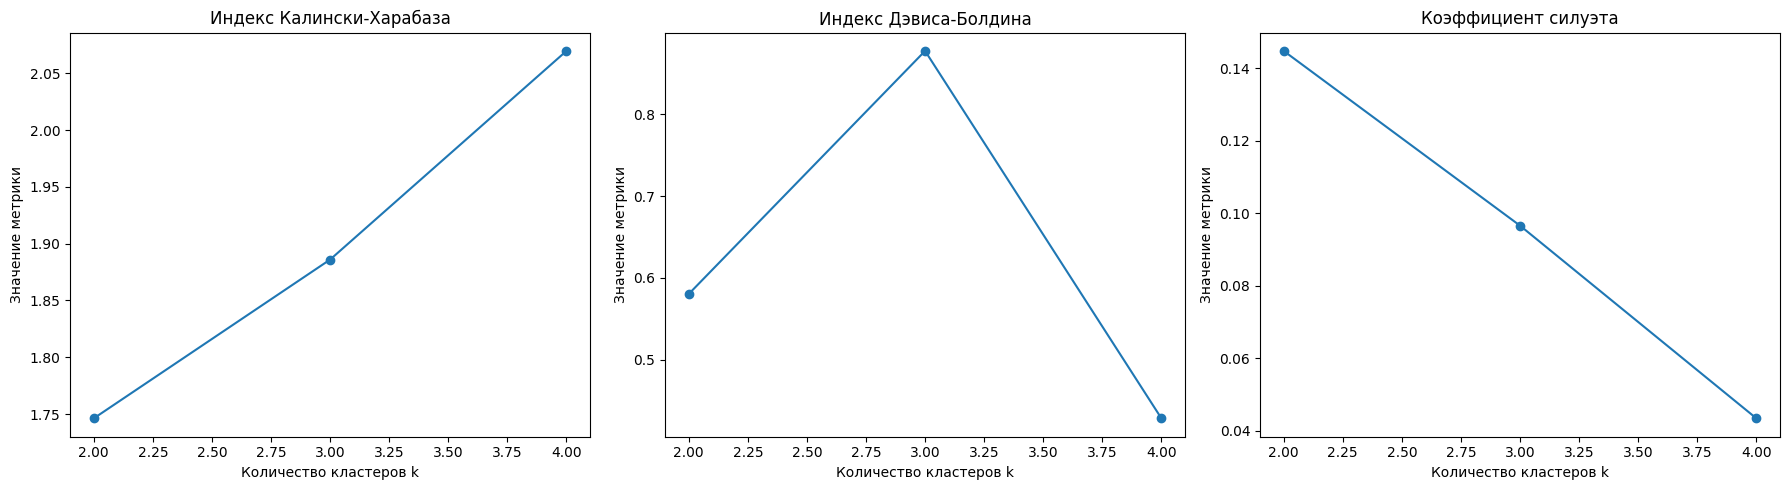

In [ ]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Диапазон значений k
k_max = min(12, len(df))  # Ограничиваем верхнюю границу k на размер данных
k_range = range(2, k_max + 1)

# Списки для хранения метрик
ch_scores = []
db_scores = []
silhouette_scores = []

for k in k_range:
    # Создаем и обучаем модель KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df)

    # Проверка, что количество кластеров больше 1
    unique_labels = set(labels)
    if len(unique_labels) > 1:  # Убедимся, что есть больше одного кластера
        # Вычисляем метрики
        try:
            ch_score = calinski_harabasz_score(df, labels)
            db_score = davies_bouldin_score(df, labels)
            silhouette_avg = silhouette_score(df, labels)

            # Сохраняем метрики
            ch_scores.append(ch_score)
            db_scores.append(db_score)
            silhouette_scores.append(silhouette_avg)
        except ValueError as e:
            # Если произошла ошибка при вычислении метрик, выводим предупреждение
            print(f"Ошибка при вычислении метрик для k={k}: {e}")
            ch_scores.append(float('nan'))
            db_scores.append(float('nan'))
            silhouette_scores.append(float('nan'))
    else:
        # Если количество кластеров не больше 1, добавляем NaN
        ch_scores.append(float('nan'))
        db_scores.append(float('nan'))
        silhouette_scores.append(float('nan'))

# Построение графиков
plt.figure(figsize=(18, 5))

# График Индекса Калински-Харабаза
plt.subplot(1, 3, 1)
plt.plot(k_range, ch_scores, marker='o')
plt.title('Индекс Калински-Харабаза')
plt.xlabel('Количество кластеров k')
plt.ylabel('Значение метрики')

# График Индекса Дэвиса-Болдина
plt.subplot(1, 3, 2)
plt.plot(k_range, db_scores, marker='o')
plt.title('Индекс Дэвиса-Болдина')
plt.xlabel('Количество кластеров k')
plt.ylabel('Значение метрики')

# График Коэффициента силуэта
plt.subplot(1, 3, 3)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Коэффициент силуэта')
plt.xlabel('Количество кластеров k')
plt.ylabel('Значение метрики')

plt.tight_layout()
plt.show()


# Пример обработки текстовых данных

In [1]:
pip install nltk pymorphy2 scikit-learn


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 41.8 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=9a007f340b8bd801443f14cb9a3de614b537a9a66e7046442b234627505ecdcf
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [2]:
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pymorphy2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Инициализация текстовых анализаторов

In [5]:
# Инициализируем лемматизатор и список стоп-слов
morph = pymorphy2.MorphAnalyzer()
russian_stopwords = stopwords.words('russian')

# Чтение данных из файла
with open('/content/articles.txt', 'r', encoding='utf-8') as f:
    content = f.read()

# Разделяем данные на статьи
articles_raw = content.split('=====')

# Извлекаем заголовки и тексты статей
titles = []
texts = []

for article in articles_raw:
    lines = article.strip().split('\n')
    if len(lines) >= 6:
        # Извлекаем заголовок и текст статьи
        title = lines[4]
        text = ' '.join(lines[5:])
        titles.append(title)
        texts.append(text)

In [6]:
texts[:2]

['Большинство из нас видит Отечественную войну 1812 года глазами ее величайшего популяризатора – Льва Толстого. Формально «Война и мир» – книга художественная, но и автор, и многие читатели воспринимали ее как эпическое полотно из реального мира, в которое Толстой просто вплел судьбы кое-каких персонажей помельче. Из-за «толстовизации» истории Отечественной войны многие до сих пор считают, что Кутузов как полководец действовал мудро. Якобы он не хотел давать Наполеону Бородинского сражения, планируя скорее отдать Москву, и только под напором Александра I и двора это сражение он дал. Более того, Кутузов не хотел жертв со стороны русской армии и поэтому избегал решительных сражений с французами при их отступлении вдоль Старой смоленской дороги, и также поэтому не окружил их под Красным, еще в глубине России, где до границы было очень далеко. По той же причине же он не хотел и решительного сражения с Наполеоном на Березине, не гнал вперед свои уставшие войска, и от этого разгром Бонапарта

#### Предварительная обработка текстовых данных

1. преобразуем в lowercase
2. оставляем только слова
3. токенизируем текста
4. преобразуем слова в начальную форму

In [7]:
russian_stopwords

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [8]:
def preprocess_text(text):
    # Приводим к нижнему регистру
    text = text.lower()
    # Удаляем пунктуацию и цифры
    text = re.sub(r'[^а-яё\s]', '', text)
    # Токенизация
    words = text.split()
    # Удаление стоп-слов и лемматизация
    lemmatized = []
    for word in words:
        if word not in russian_stopwords:
            lemma = morph.parse(word)[0].normal_form
            lemmatized.append(lemma)
    return ' '.join(lemmatized)

# Применяем предобработку к каждому тексту
texts_preprocessed = [preprocess_text(text) for text in texts]


In [9]:
texts_preprocessed[:2]

['большинство видеть отечественный война год глаз великий популяризатор лев толстой формально война мир книга художественный автор многие читатель воспринимать эпический полотно реальный мир который толстой просто вплести судьба коекакий персонаж мелкий изз толстовизация история отечественный война многие сей пора считать кутузов полководец действовать мудро якобы хотеть давать наполеон бородинский сражение планировать скорее отдать москва напор александр двор это сражение дать кутузов хотеть жертва сторона русский армия поэтому избегать решительный сражение француз отступление вдоль старый смоленский дорога также поэтому окружить красный глубина россия граница очень далеко тот причина хотеть решительный сражение наполеон березина гнать вперёд свой устать войско разгром бонапарт россия полный сопровождаться пленение осень год сожаление весь вышеперечисленный лев толстой сыграть плохой услуга популяризация российский история сегодня достоверно известно кутузов планировать дать решительн

#### Преобразуем в векторный вид

In [10]:

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts_preprocessed)


In [14]:
from sklearn.cluster import DBSCAN  # Добавьте этот импорт

# Параметры DBSCAN могут требовать подбора
dbscan = DBSCAN(eps=0.5, min_samples=2, metric='cosine')
labels = dbscan.fit_predict(X)


In [15]:
# Создаем DataFrame с заголовками и метками кластеров
df = pd.DataFrame({'title': titles, 'label': labels})

# Выводим количество кластеров
unique_labels = set(labels)
n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
print(f'Количество кластеров: {n_clusters}')

# Анализируем кластеры
for label in unique_labels:
    if label == -1:
        continue  # Пропускаем шум
    cluster_titles = df[df['label'] == label]['title'].head(3)
    print(f'\nКластер {label}:')
    for title in cluster_titles:
        print(f'- {title}')


Количество кластеров: 51

Кластер 0:
- Впервые в мире термоядерную плазму протестировали в токамаке нового поколения 
- Создан самый большой в мире термоядерный стелларатор 

Кластер 1:
- Во «ВКонтакте»  запущена биржа рекламы 
- «ВКонтакте» избавится от назойливой рекламы в ленте новостей 

Кластер 2:
- Первый китайский луноход 
- Миссия «Чанъэ-3»: Китай хочет утвердиться в качестве космической сверхдержавы 
- «Чанъэ-3» сделал фото Земли в высоком разрешении 

Кластер 3:
- Гибридное затмение над Африкой 
- В воскресенье произойдет гибридное солнечное затмение 

Кластер 4:
- LG G Flex: изогнутый – значит гибкий 
- LG G Flex – «первый в мире по-настоящему изогнутый»  смартфон 

Кластер 5:
- Будет ли Сноуден  работать во «ВКонтакте»? 
- Сноуден отказался работать в соцсети «ВКонтакте» 
- Сноуден  начнет работать в «крупнейшем российском сайте» 

Кластер 6:
- Злой двойник Земли 
- 9 самых странных экзопланет 
- Телескоп «Кеплер» обнаружил планету, похожую на Землю 

Кластер 7:
- Черная ды

In [16]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [17]:
from sklearn.decomposition import PCA
import plotly.graph_objects as go

# Применяем PCA для уменьшения размерности до 3 компонент
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X.toarray())

# Создаем DataFrame для визуализации
df_plot = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'PC3': X_pca[:, 2],
    'title': titles,
    'label': labels
})

# Создаем 3D Scatter Plot
fig = go.Figure(data=[go.Scatter3d(
    x=df_plot['PC1'],
    y=df_plot['PC2'],
    z=df_plot['PC3'],
    mode='markers',
    marker=dict(
        size=5,
        color=df_plot['label'],
        colorscale='Viridis',
        opacity=0.8
    ),
    text=df_plot['title'],
    hovertemplate='%{text}<extra></extra>'
)])

# Настраиваем внешний вид графика
fig.update_layout(
    title='3D PCA визуализация статей',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    margin=dict(l=0, r=0, b=0, t=50)
)

# Генерируем кадры для анимации вращения графика
frames = []
for angle in range(0, 360, 10):
    camera = dict(
        eye=dict(x=2*np.cos(np.radians(angle)), y=2*np.sin(np.radians(angle)), z=1.5)
    )
    frames.append(go.Frame(layout=dict(scene_camera=camera)))

# Добавляем кадры в график
fig.frames = frames

# Добавляем кнопки управления анимацией
fig.update_layout(
    updatemenus=[dict(
        type='buttons',
        showactive=False,
        y=0.8,
        x=1.05,
        xanchor='left',
        yanchor='top',
        buttons=[dict(label='Вращать',
                      method='animate',
                      args=[None, dict(frame=dict(duration=50, redraw=True),
                                       transition=dict(duration=0),
                                       fromcurrent=True,
                                       mode='immediate')])]
    )]
)

# Отображаем график
fig.show()
